## Olist research

Цели:
- Определение причин недоставок товара, 
- Расчет показателей
    - Количество пользователей, которые совершили покупку только один раз.
    - Количество заказов в месяц в среднем, которые не доставляются по разным причинам.
    - По каждому товару определить, в какой день недели товар чаще всего покупается.
- Когортный анализ пользователей.
- RFM-сегментацию пользователей.

Содержание

0. Подключение библиотек и настройка параметров  
1. Выгрузка и изучение имеющихся данных  
1.1. Анализ данных покупателей из "olist_customers_dataset"  
1.2. Анализ данных о товарных позициях в заказах из "olist_order_items_dataset"  
1.3. Анализ данных о статусах заказов из "olist_orders_dataset"  
1.4. Доступная информация о компании и положении дел в данном сегменте  
2. Предварительная подготовка данных  
2.1. Определение временного интервала для анализа данных  
2.2. Вариации жизненного пути заказов  
2.3. Продажа / Покупка  
2.4. Признаки осуществленной или не осуществленной доставки   
3. Анализ поставленных задач  
3.1. Количество пользователей, которые совершили покупку только один раз  
3.2. Количество заказов в месяц в среднем, которые не доставляются по разным причинам  
3.3. По каждому товару определить, в какой день недели товар чаще всего покупается  
3.4.1. Когортный анализ пользователей  
3.4.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц  
3.5. Построить RFM-сегментацию пользователей для качественной оценки своей аудитории  
4. Итог  

## 0. Подключение библиотек и настройка параметров

In [1]:
%matplotlib inline

# подключение библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
# Настройка отображения графиков
size = 16
params = {
    "legend.fontsize": "large",
    "figure.figsize": (16, 8),
    "axes.titlesize": size,
}
plt.rcParams.update(params)

In [3]:
import warnings

# отключение предупреждений вида "FutureWarning messages"
warnings.simplefilter(action="ignore", category=FutureWarning)

## 1. Выгрузка и изучение имеющихся данных

### 1.1. Анализ данных покупателей из "olist_customers_dataset"

In [4]:
# Считываем данные из файла в датафрейм
customers_df = pd.read_csv("olist_customers_dataset.csv")

In [5]:
# Беглый осмотр данных
customers_df.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [6]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
customers_df.describe(include="all")

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,dcca41a026a2c9326ed70adf39220274,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


Предварительные выводы по таблице покупателей (customers_df):  
- пропусков нет;    
- кол-во уникальных покупателей составляет около 96% от встречающихся. Следовательно большинство из них оплачивало лишь однажды;  
- максимальное кол-во покупок на одного клиента = 17;  
- широкий регион охвата у компании (27 штатов, 4119 населенных пунктов);
- большинство покупок совершается в штате с кодом SP (около 41%). Значительная часть из них - в городе São Paulo (Сан-Па́улу, Бразилия).

### 1.2. Анализ данных о товарных позициях в заказах из "olist_order_items_dataset"

In [8]:
# Считываем данные из файла в датафрейм и преобразовываем данные в столбце с датой и временем в соответствующий формат
order_items_df = pd.read_csv(
    "olist_order_items_dataset.csv", parse_dates=["shipping_limit_date"]
)

In [9]:
order_items_df.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [10]:
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [11]:
order_items_df.describe(include="all")

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650,112650,112650,112650.000000,112650.000000
unique,98666,NaN,32951,3095,93318,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2018-03-01 02:50:48,NaN,NaN
freq,21,NaN,527,2033,21,NaN,NaN
first,NaN,NaN,NaN,NaN,2016-09-19 00:15:34,NaN,NaN
last,NaN,NaN,NaN,NaN,2020-04-09 22:35:08,NaN,NaN
mean,NaN,1.197834,NaN,NaN,NaN,120.653739,19.990320
std,NaN,0.705124,NaN,NaN,NaN,183.633928,15.806405
min,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000
25%,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000


Предварительные выводы по таблице товарных позиций, входящих в заказы (order_items_df):  
- пропусков нет;
- 98666	заказов с ценой;
- максимальное кол-во позиций в одном заказе = 21;
- большинство заказов содержат одну позицию;
- представлена широкая линейка товаров (32951 товарных позиций), самый популярный товар приобретался 527 раз.
- производителей товаров 3095, наиболее частый встречается 2033 раза в товарных позициях заказа. Продавцы могут размещать более 1-го вида товара.
- данные собраны в промежутке между 2016-09 и 2020-04-09 (далее период будет уточнен);
- ценовой диапазон приобретаемых товаров от 0,85 до 6735 с медианной в 75;  

- ценовой диапазон за доставку товара от 0 до 409,68.  
freight_value скорее всего не "вес товара", а, судя из названия, - значения фрахта (стоимости перевозки груза).  
Подтверждено.  
Пример: product_id = 'd41dc2f2979f52d75d78714b378d4068', freight_value меняется от 12.48 до 34.15 у одного продавца.

Вместо указания количества товара, для каждой единицы товара своя строка, пример заказ '7a067b571c19eb71f647423ceba78fbe'. В нем три одинаковых товара (совпадает product_id), каждый на своей строке.

### 1.3. Анализ данных о статусах заказов из "olist_orders_dataset"

In [12]:
# Считываем данные из файла в датафрейм и преобразовываем данные в столбцах с датой и временем в соответствующий формат
orders_df = pd.read_csv(
    "olist_orders_dataset.csv",
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
    ],
)

In [13]:
orders_df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


In [14]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [15]:
# Переименование колонок в краткие формы

orders_df = orders_df.rename(
    columns={
        "order_purchase_timestamp": "purchase",
        "order_approved_at": "approved_at",
        "order_delivered_carrier_date": "carrier_get",
        "order_delivered_customer_date": "customer_get",
        "order_estimated_delivery_date": "estimated_dt",
    }
)
orders_df.head(3)

,order_id,customer_id,order_status,purchase,approved_at,carrier_get,customer_get,estimated_dt
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


In [16]:
orders_df.describe(include="all")

,order_id,customer_id,order_status,purchase,approved_at,carrier_get,customer_get,estimated_dt
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,37e543508b869d9d46e5cb9eedc85cdb,edb3ca904a6cd3caeecda1f844ebae65,delivered,2018-03-31 15:08:21,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-14 20:02:44,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522
first,NaN,NaN,NaN,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
last,NaN,NaN,NaN,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


In [17]:
# Количество заказов в разных статусах за весь период.

orders_df.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

_!!! Внимание: далее значения с датой и временем по каждому заказу будет именоваться "этапом" для удобства передачи смысла происходящего._

Предварительные выводы по таблице заказов (orders_df):  
- наличие пропусков по трём этапам заказа;
- order_estimated_delivery_date устанавливается при создании заказа.
- свыше 99% заказов с проставленным временем "подтверждения оплаты заказа" (99281 из 99441). 
- около 97% заказов со статусом "доставлено" (96476 из 99441).

### 1.4. Доступная информация о компании и положении дел в данном сегменте

Перед нами данные компании Olist (название из имени файлов + регионы в одной из таблиц и совпадение по виду деятельности).  
Olist — бразильский стартап, работающий в сегменте технологий розничной торговли. У компании есть решения, облегчающие управление офлайн- и интернет-магазинами (электронной коммерцией), а также решение для ускорения продаж внутри крупных маркетплейсов ("Амазон" и подобные). В магазин Olist интегрировано более 10 крупных веб-сайтов.   
Доступ осуществляется по SaaS модели.   
С одной стороны, Олист концентрирует продавцов, желающих разместить рекламу на таких торговых площадках, с другой стороны, он концентрирует товары всех продавцов в одном магазине, который виден конечному потребителю.  
Магазин Olist предлагает эксклюзивные преимущества, такие как:
- Высокая репутация на маркетплейсах;
- Большие шансы занять лучшие позиции (купить ящики);
- Интегрированное управление и простота эксплуатации;
- Аналитика рынка для бизнеса;
- Улучшенная поддержка магазина и покупателей;
- Команды, занимающиеся обзором каталогов и послепродажным обслуживанием;
- Больше практичности и экономии при отправке заказов благодаря эксклюзивному договору с Почтой, более привлекательной и дешевле на 15% доставки.   
(возможно часть из этого списка не была доступна в 2017-2018 годах)

Источники:
https://ajuda.olist.com/hc/pt-br/articles/4409242128916-Entenda-o-que-%C3%A9-e-como-funciona-o-Olist-Store  ,
википедия (португальская), статьи о компании в Бразильском сегменте.

Статистика из интернета (то, что было на поверхности):

Google: Средний чек на покупку по электронной торговле в Бразилии в 2018 был 119 долл. США.  

2018 год в среднем бразильцы тратили на онлайн покупки 1914 реалов в год (ок. 570 долл. США, курс реала упал).    
2017 год в среднем бразильцы тратили на онлайн покупки 1787 реалов в год (ок. 520 долл. США).   
2016 год предположим 460 долл. США.   
2015 год в среднем каждый онлайн-покупатель из Бразилии тратит 376 долл. США ежегодно.

В странах Латинской Америки есть свои локальные проблемы с доставкой грузов:

(вероятные причины несоблюдения сроков доставки)  
Местные почтовые службы, такие как Correios в Бразилии, могут доставить заказ по всей стране по относительно низкой цене, но время доставки часто непредсказуемо и продолжительно.  
Плохая инфраструктура, множество грунтовых дорог в сельской местности.  
Сложная местность, в таких регионах, как тропические леса Амазонки или Анды.  

(вероятные причины, по которым товар не доехал до клиента)  
Отсутствие адресов на карте, несогласованные почтовые индексы и адресные системы, могут привести к ошибкам доставки.  
Риск хищения грузов в районах с высоким уровнем преступности. Даже в безопасных районах есть риск, что товар украдут, особенно из пункта самовывоза.  

_Далее не привожу проверку при получении каких-либо значений, чтобы уменьшить кол-во блоков кода, поверьте, она осуществлялась._

## 2. Предварительная подготовка данных

### 2.1. Определение временного интервала для анализа данных

In [18]:
# Рассмотрим разбивку заказов по этапам и месяцу создания заказа во временном датафрейме для уточнения "рабочего" периода.

temp_df = orders_df.copy()
temp_df["create_month"] = temp_df["purchase"].astype(str).str.slice(0, 7)
temp_df.groupby("create_month").count()

,order_id,customer_id,order_status,purchase,approved_at,carrier_get,customer_get,estimated_dt
create_month,,,,,,,,
2016-09,4,4,4,4,4,2,1,4
2016-10,324,324,324,324,318,278,270,324
2016-12,1,1,1,1,1,1,1,1
2017-01,800,800,800,800,797,766,750,800
2017-02,1780,1780,1780,1780,1766,1674,1653,1780
2017-03,2682,2682,2682,2682,2680,2591,2546,2682
2017-04,2404,2404,2404,2404,2400,2352,2303,2404
2017-05,3700,3700,3700,3700,3691,3600,3545,3700
2017-06,3245,3245,3245,3245,3241,3182,3135,3245


Есть смысл рассматривать данные только за период с 2017-01 по 2018-08 включительно, причины:  
- в 2016-м неполные данные. Хоть и представлено немало заказов за октябрь 2016, но велика вероятность что была обнаружена ошибка в работе платформы, из-за чего за следующие два месяца проведен лишь один заказ.  
_<Если включить данные за 2016 год для рассмотрения, то на шаге с отображением "возможных жизненных путей заказа в зависимости от этапа и статуса" (он представлен ниже) можно заметить несколько новых аномалий.  
Например: пробитый к отправке (shipping_limit_date) отсутствующий товар (unavailable) и подобное>_  
.
- после августа 2018 заказов слишком мало, вероятно из-за некорректной выгрузки данных.  
В октябре 2018 в 400 раз меньше заказов, чем в августе. Это не связано с крахом компании, т.к. на момент получения данных (когда бы это условно не произошло с 2018 по 2024), мы знаем, что компания существует и здравствует.

In [19]:
# Используем данные только за период с 2017-01 по 2018-08 включительно.

start_date = "2017-01-01 00:00:00"
end_date = "2018-09-01 00:00:00"

orders_df = orders_df.query("purchase >= @start_date and purchase < @end_date")
print(f"Количество записей = {len(orders_df)}\n")
print(f"Минимальная дата создания заказа = {orders_df.purchase.min()}\n")
print(f"Максимальная дата создания заказа = {orders_df.purchase.max()}\n")

Количество записей = 99092

Минимальная дата создания заказа = 2017-01-05 11:56:06

Максимальная дата создания заказа = 2018-08-31 16:13:44



### 2.2. Вариации жизненного пути заказов

Чтобы определится что именно считать покупкой и какие заказы считать доставленными/недоставленными, необходимо более детально рассмотреть изменение статусов заказов.  

Данный шаг позволит увидеть взаимосвязь статуса заказа с проставленными по времени этапами, возможные аномалии, зависимость различных этапов друг от друга, предположить возможные причины отмены заказов.

In [20]:
# Подтянем в датафрейм orders_df значение shipping_limit_date,
# чтобы в дальнейшем проанализировать зависит ли превышение данного срока на статус заказа.

# Создаём новый датафрейм, берем только 2 поля, без дубликатов номера заказа
items_and_shipping_limits_df = (
    order_items_df[["order_id", "shipping_limit_date"]]
    .drop_duplicates(subset=["order_id"])
    .reset_index(drop=True)
)

# Записываем в новый датафрейм order_path_df данные из orders_df с подтянутыми значениями shipping_limit_date
order_path_df = orders_df.merge(
    items_and_shipping_limits_df, how="left", on="order_id"
).drop("customer_id", axis=1)  # customer_id для данной задачи не пригодится


order_path_df.head(3)

,order_id,order_status,purchase,approved_at,carrier_get,customer_get,estimated_dt,shipping_limit_date
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07-30 03:24:27
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08-13 08:55:23


In [21]:
# С помощью функции melt разнесём этапы заказа по строкам
order_path_melted_df = order_path_df.melt(
    id_vars=["order_id", "order_status"],
    value_vars=[
        "purchase",
        "approved_at",
        "carrier_get",
        "shipping_limit_date",
        "customer_get",
        "estimated_dt",
    ],
    var_name="order_status_on_date",
    value_name="date",
).dropna().sort_values(["order_id", "date"])  # сортировка этапов по возрастанию даты и времени для каждого заказа

# Получили строки с этапами, в порядке возрастания даты этапов по каждому заказу
order_path_melted_df

,order_id,order_status,order_status_on_date,date
84966,00010242fe8c5a6d1ba2dd792cb16214,delivered,purchase,2017-09-13 08:59:02
184058,00010242fe8c5a6d1ba2dd792cb16214,delivered,approved_at,2017-09-13 09:45:35
382242,00010242fe8c5a6d1ba2dd792cb16214,delivered,shipping_limit_date,2017-09-19 09:45:35
283150,00010242fe8c5a6d1ba2dd792cb16214,delivered,carrier_get,2017-09-19 18:34:16
481334,00010242fe8c5a6d1ba2dd792cb16214,delivered,customer_get,2017-09-20 23:43:48
...,...,...,...,...
158626,fffe41c64501cc87c801fd61db3f6244,delivered,approved_at,2018-06-09 17:10:13
257718,fffe41c64501cc87c801fd61db3f6244,delivered,carrier_get,2018-06-11 14:11:00
356810,fffe41c64501cc87c801fd61db3f6244,delivered,shipping_limit_date,2018-06-12 17:10:13
455902,fffe41c64501cc87c801fd61db3f6244,delivered,customer_get,2018-06-14 17:56:26


In [22]:
# объединяем строки в списки этапов (от самого раннего к последующим) для каждого заказа
orders_status_lists = (
    order_path_melted_df.groupby(["order_id", "order_status"])
    .order_status_on_date.apply(list)
    .reset_index()
)

# соединяем элементы списка со вставкой стрелки (для наглядности)
orders_status_lists["path"] = orders_status_lists["order_status_on_date"].apply(
    lambda x: " -> ".join(x)
)

# удаляем столбец с промежуточным итогом
orders_status_lists = orders_status_lists.drop("order_status_on_date", axis=1)

# Формируем итоговую таблица с вариантами "жизненного пути" заказов в зависимости от этапов и статусов
orders_paths = (
    orders_status_lists.groupby("order_status")["path"]
    .value_counts()
    .to_frame()
    .rename(columns={"path": "quantity"})
)

orders_paths

quantity
order_status path                                                        
approved     purchase -> approved_at -> shipping_limit_date ...         2
canceled     purchase -> approved_at -> shipping_limit_date ...       370
             purchase -> estimated_dt                                 116
             purchase -> approved_at -> carrier_get -> shipp...        61
             purchase -> approved_at -> estimated_dt                   16
...                                                                   ...
shipped      purchase -> carrier_get -> approved_at -> shipp...         8
             purchase -> approved_at -> carrier_get -> estim...         2
             carrier_get -> purchase -> approved_at -> shipp...         1
unavailable  purchase -> approved_at -> estimated_dt                  599
             purchase -> estimated_dt -> approved_at                    3

[65 rows x 1 columns]

In [23]:
# При желании, раскомментируйте код ниже, чтобы скачать файл

# orders_paths.to_excel("orders_paths.xlsx")

__Анализ файла дал следующие результаты:__  
- Если максимальная дата доставки продавцом для передачи заказа партнеру по логистике ("shipping_limit_date") превышает время передачи заказа в логистическую службу ("order_delivered_carrier_date") заказ может быть доставлен. 

- Аналогично с "обещанной датой доставки" клиенту, она нередко превышается. (возможные причины указаны ранее).

- Не везде проставленное время соответствует логике.  
Например: доставка товара в логистическую службу до создания самого заказа или получение товара покупателем до получения товара логистической компанией.

- Присутствуют случаи пропуска некоторых этапов.  
(подробнее в следующих блоках кода)

- Значения в order_status не обновляются должным образом. 
Например: заказы с "approved", "invoiced", "processing", "unavailable", "shipped", по которым уже давно истек срок (2017 г.), должны были уже (к осени 2018 г.) автоматически переместиться в "canceled" или в "delivered", если доставка имело место быть, но не прошла по программе.  

- Статус "unavaliable" (недоступен). Скорее всего возникает при отсутствии товарных позиций на складе поставщика.  
Возможная причина: остатки отображались не верно на сайте.

In [24]:
# Нестыковки.
# <Эти два блока - несущественная часть работы, дабы скрыть вывод блоков, закомментировал.
# При желании, раскомментируйте код и запустите ячейки.>

# Заказы с датой передачи в логистическую службу и без отметки о якобы оплате (approved_at)
# order_path_df.query("approved_at.isnull() & shipping_limit_date.notnull()")

# -- 14 шт., все заказы в статусе "доставлен",
# имеют следующие даты создания: 2017-01-19, 2017-02-17, 2017-02-18.
# Помимо данных заказов были десятки других в эти даты, подобной аномалии у остальных нет.
# Наиболее вероятная причина: сбой.

In [25]:
# Другие записи по заказам с пропусками этапов:

# "доставленные" без даты в "customer_get"
# order_path_df.query("order_status == 'delivered' & customer_get.isnull()")
# -- 8 шт.

# "доставленные" без даты в "carrier_get" с датой в  "customer_get"
# order_path_df.query("order_status == 'delivered' & carrier_get.isnull() & customer_get.notnull()")
# -- 1 шт.

Все вышеперечисленные заказы с пропущенными этапами со статусом "delivered" далее учитываем как оплаченные и доставленные клиенту.

Для наглядности и удобства разделим весь "жизненный путь" заказа на __СТАДИИ__:  
(+ означает заполненную дату и время на указанном этапе)

1. Заказ СОЗДАН (скорее всего сразу после оплаты клиентом).  
order_purchase_timestamp (purchase) + 

2. ПОДТВЕРЖДЁНО получение оплаты.  
order_approved_at (approved_at) + 

3. НАЛИЧИЕ ТОВАРА у продавца/-цов проверено. Товар собирается и отправляется в логистическую службу.  
shipping_limit_date +

4. ПЕРЕДАН в логистическую службу для доставки клиенту.  
order_delivered_carrier_date (carrier_get) +

5. ДОСТАВЛЕН клиенту.  
order_estimated_delivery_date (customer_get) +  или статус "delivered"  

Создадим датафрейм с разбивкой заказов на стадии, для дальнейшей работы.

In [26]:
# Функция, которая создаёт столбец 'stage' (стадия) на основе наличия этапов у заказа
def new_column_value(row):
    if (row[1] == "delivered") | (pd.notnull(row[5])):  # "delivered" или customer_get +
        return "5"
    elif pd.notnull(row[4]):  # carrier_get +
        return "4"
    elif pd.notnull(row[7]):  # shipping_limit_date +
        return "3"
    elif pd.notnull(row[3]):  # approved_at +
        return "2"
    else:  # purchase +
        return "1"

Заказы со статусом "canceled" (отмененные) будут учтены согласно произошедшему с заказом событию (создан / собран / доставлен в лог. службу / клиенту), как и все остальные статусы.

In [27]:
# создаём временный датафрейм из копии существующего, для безопасных манипуляций с данными
temp2_df = order_path_df.copy()

# Применим функцию к новому столбцу датафрейма
temp2_df["stage"] = temp2_df.apply(new_column_value, axis=1)

# количество заказов на разных стадиях
temp2_df.stage.value_counts()

5    96212
4     1166
3      975
2      618
1      121
Name: stage, dtype: int64

In [28]:
# Наглядно таблица количества заказов с разными статусами и на разных стадиях
status_stage_pt = pd.pivot_table(
    temp2_df,
    values="order_id",
    index=["order_status"],
    columns=["stage"],
    aggfunc="count",
)

status_stage_pt.fillna("-")

stage,1,2,3,4,5
order_status,,,,,
approved,-,-,2,-,-
canceled,116,16,378,69,1
created,5,-,-,-,-
delivered,-,-,-,-,96211
invoiced,-,-,296,-,-
processing,-,-,299,-,-
shipped,-,-,-,1097,-
unavailable,-,602,-,-,-


### 2.3. Продажа / Покупка

Учитывая специфику бизнеса, покупкой должно быть приобретение пакетов услуг компании розничными торговцами, но соответствующих данных у нас нет.  
Следовательно, под "покупками" будем подразумевать продажи розничных торговцев с использованием сервиса данной компании.  

Варианты что считать "покупкой":  
1) все представленные заказы, так как номер создания заказа выдаётся при оплате.  
Но оплата не всегда подтверждается. Вариант не подходит.

2) все заказы с "время подтверждения оплаты заказа" (факт что оплата прошла).  
Минус подхода: среди данных заказов, есть такие, которые не были собраны продавцами и не были отправлены далее по логистической цепочке. Данные по таким заказам отсутствуют в order_items_df (olist_order_items_dataset.csv), по ним неизвестна стоимость заказа. Это 100% возвраты сумм. Вариант не подходит. 

3) ориентироваться на заказы со статусом, например, approved или последующим, то есть заказы присутствующие в order_items_df (собранные и отправленные в логистическую службу).   
Оплачены, подтверждена оплата (покупка состоялась) и наличие товара у продавца.  
Заказы укомплектованы и имеет дату shipping_limit_date (имеется стоимость заказа).   
Заказы со статусами: invoiced, approved, processing, shipped, delivered и часть из canceled (с соответствующими признаками). Это соответствует стадиям 3-5 включительно.   
_Интересный вариант_

4) только заказы со статусом "delivered".  
Как 100% совершенные. Данный вариант больше подходит для другой модели бизнеса.

Выбор - __вариант 3__.

' _напоминаю, работа с данными за период с 2017-01 по 2018-08 включительно_

In [29]:
# Подготовим датасет продаж (покупок). Он будет включать следующие признаки (столбцы):
# id покупателя, id заказа, дату покупки, кол-во товарных позиций, сумму заказа с учетом фрахта.

# Создаём новый датасет из копии
paid_orders_df = orders_df.copy()

# Датой продажи будем считать "время подтверждения оплаты заказа", 
# для доставленных заказов без данного этапа датой продажи будет считаться дата доставки клиенту.

# Взятие даты из первого столбца, если она отсутствует, то из второго (для заказов "delivered" без "approved_at")
paid_orders_df["sale_date"] = paid_orders_df["approved_at"].combine_first(
    orders_df["customer_get"]
)

# Расчет сумм заказов с учетом стоимости фрахта
order_items_df["total_cost"] = order_items_df.price + order_items_df.freight_value
order_cost_df = (
    order_items_df.groupby("order_id", as_index=False)
    .agg(
        {"total_cost": "sum", "order_item_id": "max"}
    )  # на всякий случай посчитаем кол-во товарных позиций в каждом заказе
    .rename(columns={"order_item_id": "n_items"})
)

# Добавляем столбцы с суммой заказа и количеством товарных позиций.
# Способ объединения "inner", позволяет сразу убрать строки отсутствующие в order_cost_df (без цены и "shipping_limit_date")
# и одновременно не включать строки из order_cost_df, которые не попадают в выбранный временной интервал.
paid_orders_df = paid_orders_df.merge(
    order_cost_df[["order_id", "total_cost", "n_items"]], on="order_id", how="inner"
)

# Добавляем customer_unique_id
paid_orders_df = paid_orders_df.merge(
    customers_df[["customer_id", "customer_unique_id"]], on="customer_id", how="left"
)

# Оставляем необходимые столбцы для итогового датафрейма покупок
sales_df = paid_orders_df[
    ["customer_unique_id", "order_id", "sale_date", "n_items", "total_cost"]
]

print(f"Количество оплаченных заказов = {sales_df.shape[0]}")

# Полученный датафрейм продаж
sales_df.head(3)

Количество оплаченных заказов = 98353


,customer_unique_id,order_id,sale_date,n_items,total_cost
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,1,38.71
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,1,141.46
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,1,179.12


In [30]:
# Расчет доля отмененных заказов среди оплаченных <может пригодится>
n_canceled = round(
    paid_orders_df.query("order_status == 'canceled'").shape[0] / len(paid_orders_df), 4
)
print(f"Доля отмененных заказов среди оплаченных = {n_canceled:.2%}")

Доля отмененных заказов среди оплаченных = 0.46%


### 2.4. Признаки осуществленной или не осуществленной доставки

##### Доставленые клиенту (стадия 5):
 - имеют статус delivered, 
 - canceled с этапом "время доставки заказа" клиенту ( = отказ после получения заказа, 1 заказ). 

In [31]:
# датасет доставленных заказов:
delivered_df = orders_df.query(
    "(order_status == 'delivered') | (customer_get.notnull())"
)
print(f"Количество доставленных заказов = {delivered_df.shape[0]}")

Количество доставленных заказов = 96212


##### Не доставленные - все остальные заказы (стадии 1-4)

In [32]:
# датасет НЕдоставленных заказов:

not_delivered_df = (
    orders_df.drop(delivered_df.index)
    .drop("customer_get", axis=1)
    .reset_index(drop=True)
)
print(f"Количество НЕдоставленных заказов = {not_delivered_df.shape[0]}")

Количество НЕдоставленных заказов = 2880


## 3. Анализ поставленных задач

### 3.1. Количество пользователей, которые совершили покупку только один раз

In [33]:
# Посчитаем количество всех покупателей:
buyers_number = sales_df.customer_unique_id.nunique()
# print(f"Количество уникальных пользователей, совершивших покупки = {buyers_number}\n")


# Расчёт искомого количества:
bought_once = (
    sales_df.groupby("customer_unique_id", as_index=False)
    .agg({"order_id": "count"})
    .query("order_id == 1")
)
print(f"Количество пользователей, совершивших только одну покупку = {len(bought_once)}")

# Расчет доли разовых покупателей
bought_once_ratio = len(bought_once) / buyers_number
print(
    f"Доля совершивших только одну покупку от всех покупателей = {bought_once_ratio:.2%}"
)

Количество пользователей, совершивших только одну покупку = 92221
Доля совершивших только одну покупку от всех покупателей = 96.95%


### 3.2. Количество заказов в месяц в среднем, которые не доставляются по разным причинам
(вывести детализацию по причинам)

У нас есть общее количество недоставленных заказов сгруппированных по разным статусам и стадиям.  
Чтобы узнать среднее в месяц, необходимо посчитать количество месяцев, затем общее количество недоставленных заказов разделить на полученное количество месяцев.

In [34]:
# Определение минимальной и максимальной даты создания недоставленных заказов.
min_date = not_delivered_df["purchase"].min()
max_date = not_delivered_df["purchase"].max()
print(f"Заказы не доставлялись в период с {min_date.date()} по {max_date.date()}.")

# Вычисление разницы в месяцах с учетом, что в месяц минимальной даты тоже не были доставлены товары (+1).
months_diff = (max_date.year - min_date.year) * 12 + max_date.month - min_date.month + 1
print(f"Рассматриваем период в течении {months_diff} месяцев.")

Заказы не доставлялись в период с 2017-01-08 по 2018-08-31.
Рассматриваем период в течении 20 месяцев.


In [35]:
# Подготовим датафрейм со стадиями заказа для визуализации
# Убераем 5-ю стадию, разделим значения на число месяцев и получим среднее за месяц
customers_tears = status_stage_pt.drop("delivered", axis=0).iloc[:, :-1] / 20
customers_tears.rename(
    columns={
        "1": "1. Не подтверждён",
        "2": "2. Не собран",
        "3": "3. Не отгружен",
        "4": "4. Не доставлен клиенту",
    },
    inplace=True,
)

# Транспонируем таблицу для визуализации результата
customers_tears = customers_tears.T

# === Искомый результат ===
customers_tears.fillna("-")

order_status,approved,canceled,created,invoiced,processing,shipped,unavailable
stage,,,,,,,
1. Не подтверждён,-,5.80,0.25,-,-,-,-
2. Не собран,-,0.80,-,-,-,-,30.1
3. Не отгружен,0.1,18.90,-,14.8,14.95,-,-
4. Не доставлен клиенту,-,3.45,-,-,-,54.85,-


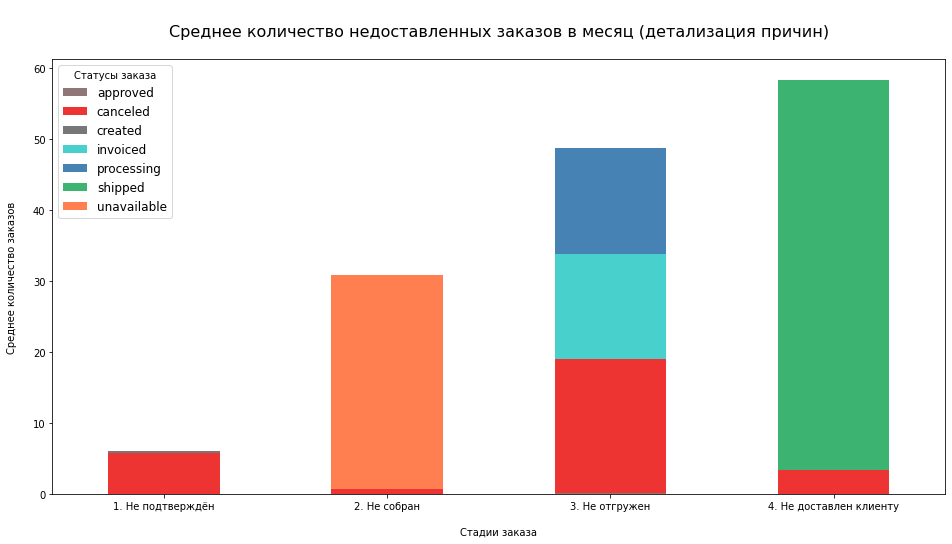

In [36]:
# Визуализация результата
colors = ["#907777", "#e33", "#777", "#48D1CC", "#4682B4", "#3CB371", "#FF7F50"]
customers_tears.plot(kind="bar", stacked=True, color=colors)
plt.title("\nСреднее количество недоставленных заказов в месяц (детализация причин)\n")
plt.xlabel("\nСтадии заказа")
plt.xticks(rotation=0)
plt.ylabel("Среднее количество заказов\n")
plt.legend(title="Статусы заказа")

__Выводы:__    
1-я стадия самая малочисленная, и вызвана скорее всего проблемами на стороне клиента/платежной организации.  
2-я стадия - отсутствие товара у розничных продавцов.  
3-я стадия - розничный продавец не отгрузил товар в логистическую службу.  
4-я стадия самая многочисленная, причины упоминались выше (местность + дороги, ошибка адреса, криминальная ситуация).

### 3.3. По каждому товару определить, в какой день недели товар чаще всего покупается

In [37]:
# Объединяем order_items_df с sales_df, чтобы для каждого товара в каждом заказе определить дату продажи
product_df = pd.merge(
    order_items_df[["order_id", "product_id"]],
    sales_df[["order_id", "sale_date"]],
    on="order_id",
)

# Определяем из дат продаж день недели
product_df["sale_day_of_week"] = product_df["sale_date"].dt.day_name()
product_df.head(3)

,order_id,product_id,sale_date,sale_day_of_week
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 09:45:35,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 11:05:13,Wednesday
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:48:30,Sunday


In [38]:
# В какой день недели каждый товар чаще всего покупается.
products_days = (
    product_df.groupby(["product_id", "sale_day_of_week"], as_index=False)
    .agg(
        {"order_id": "count"}
    )  # подсчитываем кол-во продаж товара в разрезе товар и день недели
    .rename(columns={"order_id": "quantity"})
    .sort_values(
        "quantity", ascending=False
    )  # сортируем по уменьшению количества проданного товара в этот день
    .drop_duplicates(
        subset=["product_id"]
    )  # оставляем только первый максимальный результат по каждому товару
    .reset_index(drop=True)  # обновляем индексацию таблицы
)

# === Искомый результат ===
products_days

,product_id,sale_day_of_week,quantity
0,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
1,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
2,422879e10f46682990de24d770e7f83d,Tuesday,89
3,99a4788cb24856965c36a24e339b6058,Tuesday,82
4,368c6c730842d78016ad823897a372db,Thursday,80
...,...,...,...
32782,63f52009dc3ddb733394e80183aed0f0,Saturday,1
32783,63f7a4366da7b3a3cb5bd2336ca15f7e,Friday,1
32784,63f916d8413bc439687d549e937d5b67,Saturday,1
32785,63f9b908e4626ece2e47cec24ff8dd9c,Thursday,1


В данном варианте подсчитывается количество каждого проданного товара в определенный день недели.  
Если в заказе несколько одинаковых товаров, то каждый из них учитывается как продажа этого товара.  
Необходимости выводить несколько дней в случае, если количеств продаж в разные дни недели было одинаковым, - нет (на значимом количестве (более 7 в день) таких совпадений не обнаружено).

<--  Дополнительная часть  -->

In [39]:
# топ-10/100/1000 посмотреть будет ли отрыв по определенному дню недели
top_products = order_items_df.product_id.value_counts().head(10).index.to_list()
# чтобы посмотреть другой варант выборки по количеству, просто смените значение в head() и перезапустите ячейку

# Оставляем значения только топовых продуктов в датафрейме, фильтруя товары по соответствующему списку
top_products_days = (
    product_df[product_df["product_id"].isin(top_products)]
    .groupby("sale_day_of_week", as_index=False)
    .agg({"order_id": "count"})
    .rename(columns={"order_id": "quantity"})
)

# добавим столбец с соотношением кол-ва приобретенных заказов в этот день недели к общему кол-ву приобретенных заказов
top_products_days["ratio"] = (
    top_products_days.quantity / top_products_days.quantity.sum()
)
top_products_days

,sale_day_of_week,quantity,ratio
0,Friday,604,0.155951
1,Monday,440,0.113607
2,Saturday,494,0.127550
3,Sunday,332,0.085722
4,Thursday,598,0.154402
5,Tuesday,790,0.203976
6,Wednesday,615,0.158792


In [40]:
sales_df.n_items.value_counts(normalize=True).head(3)

1    0.900694
2    0.076164
3    0.013391
Name: n_items, dtype: float64

__Выводы__   
Покупают меньше всего с субботы по понедельник (провал в воскресенье) и больше всего - во вторник.  
Заказов на 1-3 товара составляют 99% от всех заказов.  
Распределение по популярным для покупки дням недели для топ-10 / 100 / 1000 / 10000 / всех товаров - почти не отличается (диапазон колебаний по каждому дню около 1% от общей суммы).  

Еще один довод в пользу генерации данных.

### 3.4.1. Когортный анализ пользователей

In [44]:
# Определяем когорты как месяц первой покупки клиента (= минимальный)
cohorts_df = (
    temp3_df.groupby("customer_unique_id", as_index=False)
    .agg({"year_month": "min"})
    .rename(columns={"year_month": "cohorts"})
)

cohorts_df

,customer_unique_id,cohorts
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11
...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06
95117,fffea47cd6d3cc0a88bd621562a9d061,2017-12
95118,ffff371b4d645b6ecea244b27531430a,2017-02
95119,ffff5962728ec6157033ef9805bacc48,2018-05


In [45]:
# подтягиваем год-месяц по каждому заказу
merged_df = pd.merge(
    temp3_df[["customer_unique_id", "year_month"]],
    cohorts_df[["customer_unique_id", "cohorts"]],
    on="customer_unique_id",
)

merged_df

,customer_unique_id,year_month,cohorts
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
1,7c396fd4830fd04220f754e42b4e5bff,2017-09,2017-09
2,af07308b275d755c9edb36a90c618231,2018-07,2018-07
3,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08
4,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11
...,...,...,...
98348,6359f309b166b0196dbf7ad2ac62bb5a,2017-03,2017-03
98349,da62f9e57a76d978d02ab5362c509660,2018-02,2018-02
98350,737520a9aad80b3fbbdad19b66b37b30,2017-08,2017-08
98351,5097a5312c8b157bb7be58ae360ef43c,2018-01,2018-01


In [46]:
# проставим для каждой покупки соответствующий порядковый номер периода жизни когорты
merged_df["cohorts_period"] = merged_df["year_month"] - merged_df["cohorts"]
merged_df["cohorts_period"] = merged_df.cohorts_period.apply(lambda x: x.n) + 1
merged_df

,customer_unique_id,year_month,cohorts,cohorts_period
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09,2
1,7c396fd4830fd04220f754e42b4e5bff,2017-09,2017-09,1
2,af07308b275d755c9edb36a90c618231,2018-07,2018-07,1
3,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08,1
4,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11,1
...,...,...,...,...
98348,6359f309b166b0196dbf7ad2ac62bb5a,2017-03,2017-03,1
98349,da62f9e57a76d978d02ab5362c509660,2018-02,2018-02,1
98350,737520a9aad80b3fbbdad19b66b37b30,2017-08,2017-08,1
98351,5097a5312c8b157bb7be58ae360ef43c,2018-01,2018-01,1


In [47]:
# Таблица с абсолютными значениями возврата пользователей (повторным заказам) по месяцам существования когорты
cohorts_pt = pd.pivot_table(
    merged_df,
    values="customer_unique_id",
    index=["cohorts"],
    columns=["cohorts_period"],
    aggfunc="count",
)

# cohorts_pt

cohorts_period,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20
cohorts,,,,,,,,,,,,,,,,,,,
2017-01,753.0,4.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,2.0,2.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1715.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,5.0,NaN
2017-03,2656.0,14.0,9.0,11.0,9.0,4.0,4.0,9.0,8.0,3.0,10.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN
2017-04,2346.0,15.0,6.0,5.0,7.0,6.0,9.0,6.0,8.0,4.0,5.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN
2017-05,3631.0,20.0,18.0,14.0,11.0,15.0,17.0,5.0,9.0,12.0,10.0,12.0,8.0,2.0,8.0,11.0,NaN,NaN,NaN
2017-06,3183.0,15.0,12.0,12.0,8.0,11.0,12.0,7.0,4.0,7.0,10.0,12.0,5.0,4.0,7.0,NaN,NaN,NaN,NaN
2017-07,3870.0,22.0,13.0,7.0,15.0,7.0,12.0,4.0,8.0,10.0,8.0,12.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN
2017-08,4253.0,28.0,17.0,11.0,16.0,24.0,11.0,11.0,5.0,7.0,10.0,7.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4186.0,27.0,20.0,18.0,17.0,15.0,9.0,9.0,13.0,8.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# выделяем значения количества продаж в первом периоде для дальнейшего расчета относительного коэф. удержания пользователей
cohorts_group_size = (
    merged_df.query("cohorts_period == 1")
    .groupby("cohorts")
    .agg({"cohorts_period": "count"})
    .rename(columns={"cohorts_period": "cohort_size"})
)

cohorts_group_size_ser = cohorts_group_size.iloc[:, 0]
# cohorts_group_size_ser

cohorts
2017-01     753
2017-02    1715
2017-03    2656
2017-04    2346
2017-05    3631
2017-06    3183
2017-07    3870
2017-08    4253
2017-09    4186
2017-10    4440
2017-11    7184
2017-12    5662
2018-01    7002
2018-02    6552
2018-03    7119
2018-04    6604
2018-05    6846
2018-06    5964
2018-07    6011
2018-08    6425
Freq: M, Name: cohort_size, dtype: int64

In [49]:
# Таблица относительного коэффициента удержания пользователей
user_retention = cohorts_pt.divide(cohorts_group_size_ser, axis=0).round(5)
user_retention.fillna("-")

cohorts_period,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20
cohorts,,,,,,,,,,,,,,,,,,,
2017-01,1.0,0.00531,0.00266,0.00133,0.00398,0.00133,0.00398,0.00133,0.00133,-,0.00266,0.00266,0.00664,0.00398,0.00133,0.00133,0.00266,0.00398,0.00133
2017-02,1.0,0.00233,0.00233,0.00175,0.00408,0.00117,0.00233,0.00175,0.00058,0.00175,0.00117,0.00292,0.00117,0.00175,0.00117,0.00058,0.00058,0.00292,-
2017-03,1.0,0.00527,0.00339,0.00414,0.00339,0.00151,0.00151,0.00339,0.00301,0.00113,0.00377,0.00113,0.00226,0.00113,0.00151,0.00226,0.00075,0.00151,-
2017-04,1.0,0.00639,0.00256,0.00213,0.00298,0.00256,0.00384,0.00256,0.00341,0.00171,0.00213,0.00085,0.00085,0.00043,0.00085,0.00085,0.00213,-,-
2017-05,1.0,0.00551,0.00496,0.00386,0.00303,0.00413,0.00468,0.00138,0.00248,0.0033,0.00275,0.0033,0.0022,0.00055,0.0022,0.00303,-,-,-
2017-06,1.0,0.00471,0.00377,0.00377,0.00251,0.00346,0.00377,0.0022,0.00126,0.0022,0.00314,0.00377,0.00157,0.00126,0.0022,-,-,-,-
2017-07,1.0,0.00568,0.00336,0.00181,0.00388,0.00181,0.0031,0.00103,0.00207,0.00258,0.00207,0.0031,0.00129,0.00258,-,-,-,-,-
2017-08,1.0,0.00658,0.004,0.00259,0.00376,0.00564,0.00259,0.00259,0.00118,0.00165,0.00235,0.00165,0.00118,-,-,-,-,-,-
2017-09,1.0,0.00645,0.00478,0.0043,0.00406,0.00358,0.00215,0.00215,0.00311,0.00191,0.00263,0.00072,-,-,-,-,-,-,-


__Выводы:__   
(что-то не реальное) повторные заказы слишком редкие для платформы с уникальным сервисом в регионе.  
Необходимо работать с клиентами. Выявлять причины оттока.   
Если проблема со стороны продавцов, то вводить сертификацию для продавцов.  

### 3.4.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц

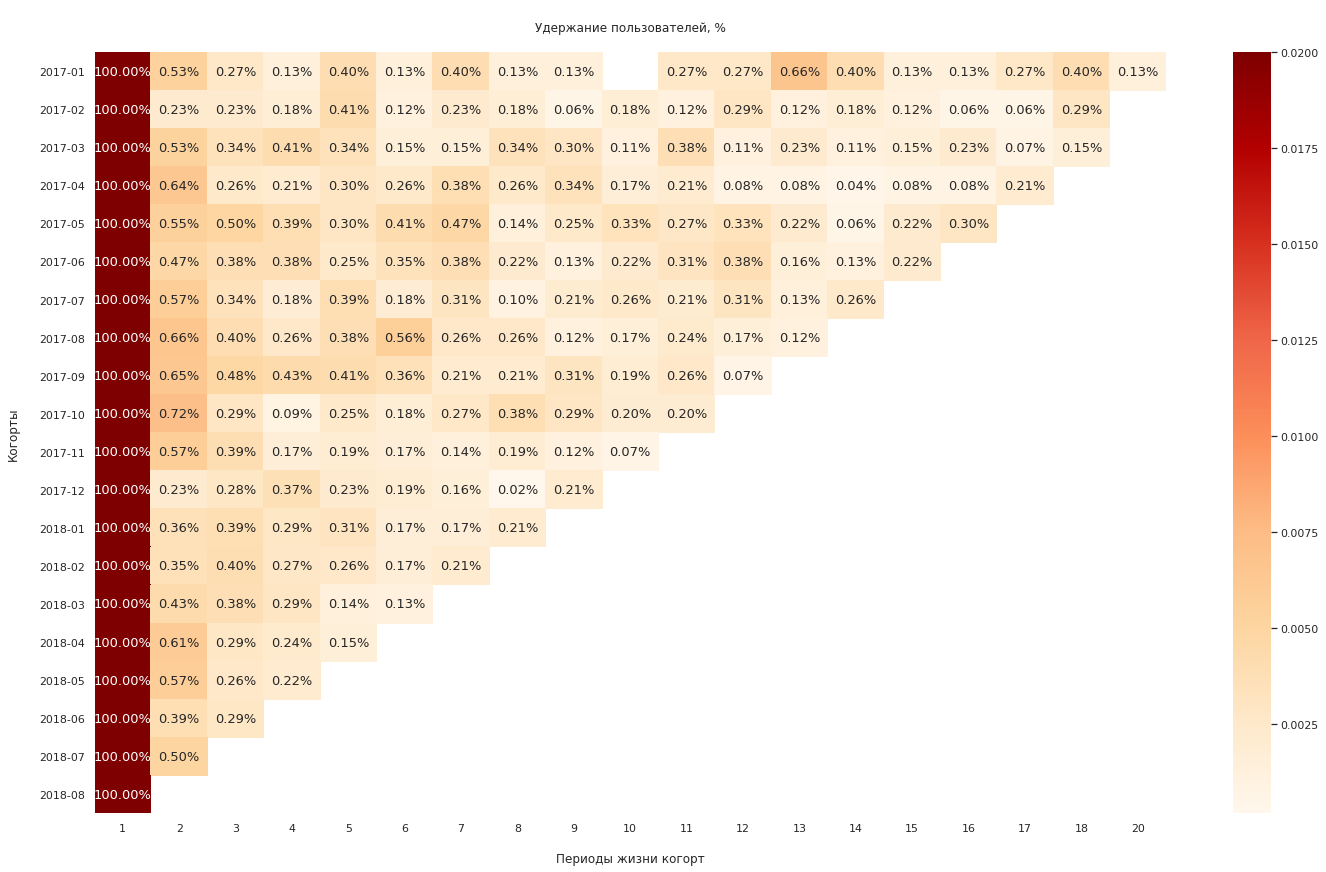

In [50]:
# Визуализируем полученную ранее таблицу относительного коэффициента удержания пользователей в виде тепловой карты

sns.set(style="white")  # устанавливаем белый стиль для графика
plt.figure(figsize=(24, 14))  # указываем ширину и высоту фигуры в дюймах
sns.heatmap(
    user_retention,
    cmap="OrRd",  # выбор цветового набора
    annot=True,
    fmt=".2%",  # определение формата значений как проценты и 2 знака после запятой
    vmax=0.02,  # сильно сместим максимальное значение для палитры, чтобы увидеть цветовую градацию.
    annot_kws={"size": 13},  # устанавливаем размер подписей значений в ячейках
    mask=user_retention.isnull()  # скрытие пустых ячеек
)
# числовые значения корреляции отображаются внутри ячеек
# подписываем название графика и оси
plt.title("\nУдержание пользователей, %\n")
plt.xlabel("\nПериоды жизни когорт")
plt.ylabel("Когорты\n");

Retention на 3-й месяц означает покупку на 4-й месяц существовании когорты.  
На тепловой карте легко находим такую - когорта "2017-09", то есть пользователи совершившие свою первую покупку в сентябре мае 2017-го.

In [51]:
# Проверим:
user_retention.iloc[:, 3].idxmax()

Period('2017-09', 'M')

### 3.5. Построить RFM-сегментацию пользователей для качественной оценки своей аудитории

RFM-аналитика помогает онлайн бизнесу повышать продажи и отклик аудитории, сокращать расходы на рекламу, делать маркетинг персонализированным и эффективным.

В кластеризации следующие метрики:  
- R - время от последней покупки пользователя до текущей даты,  
- F - суммарное количество покупок у пользователя за всё время,  
- M - сумма покупок за всё время.  

Рассчитаем данные метрики и проведем сегментацию покупателей.

In [52]:
# Работаем с копией датасета, чтобы случайно не изменить важные данные
df2 = sales_df.copy()

# Рассчитаем максимальную дату продажи, от которой будем отталкиваться
final_date = df2["sale_date"].max() + timedelta(days=1)

# Создадим столбец с разницей в днях от финальной даты и даты продажи
df2["days_since_sale"] = df2.sale_date.apply(lambda x: (final_date - x).days)

# Возьмем период в 1 календарный год
period = 365

rfm_df = (
    df2.query("days_since_sale <= @period")
    .groupby("customer_unique_id", as_index=False)
    .agg({"days_since_sale": "min", "order_id": "count", "total_cost": "sum"})
    .rename(
        columns={
            "days_since_sale": "recency",
            "order_id": "frequency",
            "total_cost": "monetary",
        }
    )
)

print(rfm_df.shape[0])
rfm_df.head(3)

74049


,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
2,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62


Для recency (времени от последней покупки) опеределим следующие границы метрики в днях:  
1) 91;  
2) 92 - 182;  
3) 183+.  

In [53]:
# Границы для Recency (времени от последней покупки)
r_border1 = 91
r_border2 = 182

In [54]:
# Рассмотрим распределение Frequency (по частоте покупок)
rfm_df.frequency.value_counts()

1     72172
2      1749
3       101
4        17
5         5
7         3
11        1
9         1
Name: frequency, dtype: int64

Для frequency (частоты) определим следующие границы метрики:  
1) одна покупка;  
2) две покупки;  
3) три и более покупок.  

In [55]:
# Рассмотрим распределение метрики суммы покупок
rfm_df.monetary.describe()

count    74049.000000
mean       165.638620
std        224.820192
min          9.590000
25%         63.220000
50%        108.350000
75%        182.860000
max      13664.080000
Name: monetary, dtype: float64

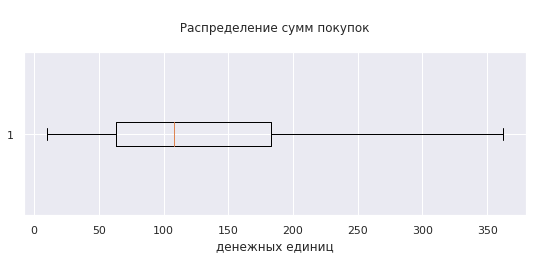

In [56]:
# Небольшая визуализация распределения суммы покупок
sns.set_theme(style="darkgrid")
plt.figure(figsize=(9, 3))

plt.boxplot(rfm_df.monetary, vert=False, showfliers=False) 
# вкл./выкл. отображение выбросов через параметр showfliers=True|False

plt.title("\n Распределение сумм покупок \n")
plt.xlabel("денежных единиц");

Разница между 75-м квантилем и максимумом огромна. Довольно большое количество выбросов.
Делать границы метрики по квантилям будет ошибкой.

Если это не в долларах США, а в реалах, то всё совсем печально: старт наших выбросов равен цене средней онлайн покупки в 2017-18г в Бразилии, тогда 90+% представленных сумм покупок находятся ниже этой отметки.

Так как 97% пользователей с 1 покупкой, то для наименования групп будет использовано слово "чек", а не "сумма покупок".

Для Monetary (суммы покупок) определим следующие границы метрики:  
1) "низкий чек"  = от 0 до 35-го перцентиля;  
2) "средний чек" = от 35-го до 70-го перцентилей;  
3) "высокий чек" = от 70-го перцентиля до значения выбросов;   
4) "крупный чек" = выбросы.  

In [57]:
# Границы для Monetary (суммы покупок) 
m_border1 = rfm_df.monetary.quantile(0.35).round(2)
m_border2 = rfm_df.monetary.quantile(0.70).round(2)
m_border3 = round(182.86 + (182.86 - 63.22) * 1.5, 2)
print(f'Границы диапазонов monetary: {m_border1}, {m_border2}, {m_border3}')

Границы диапазонов monetary: 78.1, 163.79, 362.32


In [58]:
# Функции для расчета новых столбцов с метриками, по границам новых групп 

def r_score(x):
    if x <= r_border1:
        return 3
    if x <= r_border2:
        return 2
    else:
        return 1


def f_score(x):
    if x == 1:
        return 1
    if x == 2:
        return 2
    else:
        return 3


def m_score(x):
    if x <= m_border1:
        return 1
    if x <= m_border2:
        return 2
    if x <= m_border3:
        return 3
    else:
        return 4

In [59]:
# Создаём новые столбцы для кластеризации, применяя функции
rfm_df["r"] = rfm_df["recency"].apply(lambda x: r_score(x))
rfm_df["f"] = rfm_df["frequency"].apply(lambda x: f_score(x))
rfm_df["m"] = rfm_df["monetary"].apply(lambda x: m_score(x))
# объединяем значения в один столбец
rfm_df["rfm score"] = rfm_df["r"].map(str) + rfm_df["f"].map(str) + rfm_df["m"].map(str)
rfm_df.head(3)

,customer_unique_id,recency,frequency,monetary,r,f,m,rfm score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,2,1,2,212
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,2,1,1,211
2,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,111


#### Описание сегментов    

"Топ"  
RFM: 324 и 334.  
Recency=3 (в течении последних 3-х месяцев), frequency=2+ (две и более покупок), monetary > 362,32.  
Клиенты с повторными покупками в этом сезоне и крупными чеками.  

"Лояльные"  
RFM: 321-323 и 331-333.  
Recency=3 (в течении последних 3-х месяцев), frequency=2+ (две и более покупок), monetary < 362,32.   
Совершили несколько покупок, как минимум последняя из них в последние 3 месяца.  

"Новички"  
RFM: 311-314.   
Recency=3 (в течении последних 3-х месяцев), frequency=1 (одна покупка), monetary > 0.   
Клиенты, которые совершили всего одну покупку в последние 3 месяца. (точно не повторная покупка)   
 
"Тамагочи" (нуждающиеся во внимании)  
RFM: 211-234.  
Recency=2 (от 3 до 6 месяцев), frequency (любое количество), monetary > 0.  
Все, кто совершил любое кол-во покупок, последняя из которых была более 3-х месяцев назад.  

"Засыпающие"  
RFM: 121-134.   
Recency=1 (от полугода до года), frequency=2+ (две и более покупок), monetary > 0.    
Давние клиенты, которые совершили более одной покупки.   

"Потерянные"  
RFM: 111-114.   
Recency=1 (от полугода до года), frequency=1 (одна покупка), monetary > 0.   
Давние клиенты, которые совершили всего одну покупку.   

In [60]:
# создаем столбец с названием сегмента
segment_map = {
    r"3[2-3]4": "топ",
    r"3[2-3][1-3]": "лояльные",
    r"31[1-4]": "новички",
    r"2[1-3][1-4]": "тамагочи",
    r"1[2-3][1-4]": "засыпающие",
    r"11[1-4]": "потерянные",
}

# добавляем название сегментов
rfm_df["segment"] = rfm_df["rfm score"].replace(segment_map, regex=True)
rfm_df.head(3)

,customer_unique_id,recency,frequency,monetary,r,f,m,rfm score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,2,1,2,212,тамагочи
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,2,1,1,211,тамагочи
2,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,111,потерянные


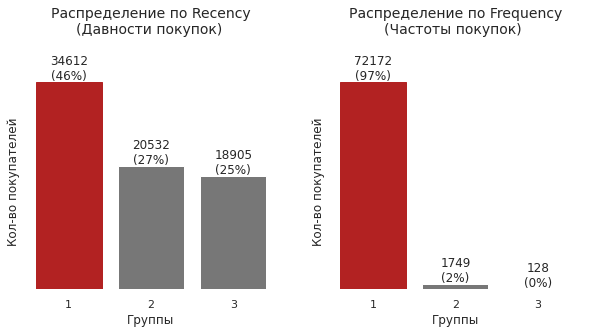

In [61]:
# график распределения сегментации покупателей по частоте и давности последней покупки
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(["r", "f"]):
    parameters = {"r": "Recency\n(Давности покупок)", "f": "Frequency\n(Частоты покупок)"}
    y = rfm_df[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color="#777")
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_xticks(x)  # указываем значения для делений по оси X
    ax.set_title("Распределение по {} \n\n".format(parameters[p]), fontsize=14)
    ax.set_xlabel("Группы")
    ax.set_ylabel("Кол-во покупателей")
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color("firebrick")
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            value,
            "{}\n({}%)".format(int(value), int(value * 100 / y.sum())),
            ha="center",
            va="bottom",
        )

Распределение по давности покупок.  
Плохой сигнал что группа "2" опережает по количеству группу "3", это означает снижение количества покупок за последние 3 месяца к предыдущим 3 месяцам примерно на 9%.

Распределение по частоте покупок - удручающее.  
На платформе представлен широкий спектр товаров различного предназначения, а количество повторных покупок слишком мало. Условия сервиса не могут быть настолько ужасными, чтобы отсеивать 97% покупателей, при количестве отмен менее 0,5% от оплаченных заказов.  
Скорее всего выборка нерепрезентативна или искусственная. О чем также свидетельствует количество ежемесячного притока пользователей (см. выше  "когорты"). Приток количества новых пользователей на подобную платформу в её первый год запуска должен ежемесячно показывать существенный рост.

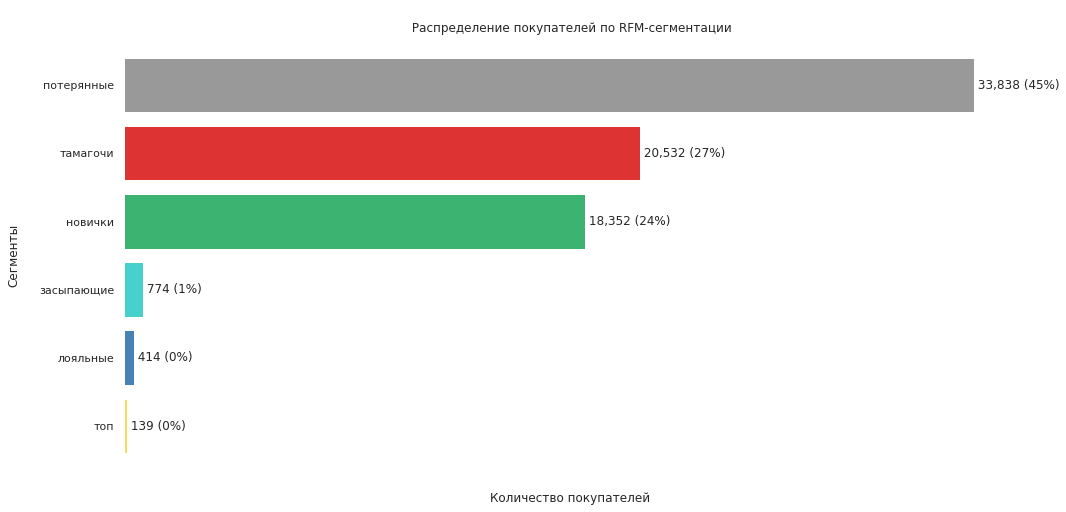

In [62]:
# Отображение количества покупателей в каждом сегменте
segments_counts = rfm_df["segment"].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()
plt.title("\n Распределение покупателей по RFM-сегментации")
plt.xlabel("\nКоличество покупателей")
plt.ylabel("Сегменты\n");

colors = ["#FADA5E", "#4682B4", "#48D1CC", "#3CB371", "#D33", "#999"]
bars = ax.barh(range(len(segments_counts)), segments_counts, color=colors)
ax.set_frame_on(False)
ax.tick_params(left=False, bottom=False, labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
    value = bar.get_width()
    ax.text(
        value,
        bar.get_y() + bar.get_height() / 2,
        " {:,} ({:}%)".format(int(value), int(value * 100 / segments_counts.sum())),
        va="center",
        ha="left",
    )

Вывод по RFM-сегментации:   
- 45% ("потерянные") отвалились, есть лишь малый шанс на их возврат.
- менее 1% ("топ" и "лояльные") осуществляют покупки более-менее постоянно,
- с остальными 54+% необходимо работать, в первую очередь поинтересоваться у "засыпающих" причинами, по которым они перестали пользоваться платформой.

В целом метод подобран неудачно для данного датасета, так как слишком мало повторных продаж (для уникальной платформы в данном регионе).

## 4. Итог

Полученные данные были подробно проанализированны.  
Создана карта вариации жизненного пути заказа и обнаружены аномалии.  
Выбран оптимальный временной период для анализа данных. В данный период меньше аномалий и он более достоверный.  
Введены и применены стадии заказа. Данный шаг позволил систематизировать статусы заказа и факт наличия товара, четко определить что является покупкой, сгруппировать причины недоставки.  

Требуемые аналитические исследования проведены в полном объеме:
- определены условия что считать "покупкой" ("продажей");
- выявлены стадии, на которых не были доставлены клиентам заказы, и указаны причины;
- определено количество пользователей, которые совершили покупку только один раз;
- и т.д. (включая когортный анализ и RFM-сегментацию)

По каждому заданию даны промежуточные выводы.

Общий вывод или какой-либо прогноз сложно предоставить, в виду странности датасета: данные либо сильно урезаны, либо сгенерированны. В обоих случаях проверять гипотезы и строить на их основе прогнозы будет ошибкой.